In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearnex import patch_sklearn
patch_sklearn()
from hpsklearn import *
from hyperopt import hp, tpe

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
SEED = 10

In [3]:
print(f"Execution started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution started at 2022-02-23 02:48:41.


In [4]:
filepath = "../Data Preprocessing/iot23_combined_2500k.csv"
df = pd.read_csv(filepath)

In [5]:
df

,Unnamed: 0,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,...,id.resp_p_23,id.resp_p_80,id.resp_p_123,id.resp_p_2323,id.resp_p_8080,id.resp_p_8081,id.resp_p_9527,id.resp_p_37215,id.resp_p_52869,id.resp_p_62336
0,70,2.999066,0,0,0,3,180,0,0,PartOfAHorizontalPortScan,...,1,0,0,0,0,0,0,0,0,0
1,79,0.000000,0,0,0,1,60,0,0,PartOfAHorizontalPortScan,...,1,0,0,0,0,0,0,0,0,0
2,83,2.998815,0,0,0,3,180,0,0,PartOfAHorizontalPortScan,...,1,0,0,0,0,0,0,0,0,0
3,97,0.000000,0,0,0,1,60,0,0,PartOfAHorizontalPortScan,...,1,0,0,0,0,0,0,0,0,0
4,101,0.000000,0,0,0,1,60,0,0,PartOfAHorizontalPortScan,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,2229370,0.000000,0,0,0,1,68,0,0,Benign,...,0,0,0,0,0,0,0,0,0,0
112646,2290883,0.000000,0,0,0,1,56,0,0,Benign,...,0,0,0,0,0,0,0,0,0,0
112647,2306017,0.000000,0,0,0,1,68,0,0,Benign,...,0,0,0,0,0,0,0,0,0,0
112648,2347856,0.000000,0,0,0,1,40,0,0,PartOfAHorizontalPortScan,...,1,0,0,0,0,0,0,0,0,0


In [6]:
del df['Unnamed: 0']

In [7]:
df['label'].value_counts()

DDoS                                             43892
PartOfAHorizontalPortScan                        33727
Benign                                           28219
Okiru                                             6788
C&C                                                  9
-   Malicious   C&C-HeartBeat-Attack                 9
-   Malicious   C&C-PartOfAHorizontalPortScan        3
C&C-FileDownload                                     1
C&C-HeartBeat-FileDownload                           1
Attack                                               1
Name: label, dtype: int64

In [8]:
good = 'Benign'
bad = 'PartOfAHorizontalPortScan'
filtered_labels = df['label'].value_counts().index.drop([good,bad])
for label in filtered_labels:
    df.drop(df[df.label == label].index, inplace=True)

In [9]:
df['label'].value_counts()

PartOfAHorizontalPortScan    33727
Benign                       28219
Name: label, dtype: int64

In [10]:
df.loc[(df.label == good), 'label'] = 0
df.loc[(df.label == bad), 'label'] = 1
df = df.astype({'label': int})

In [11]:
df['label'].value_counts()

1    33727
0    28219
Name: label, dtype: int64

In [12]:
df

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_icmp,...,id.resp_p_23,id.resp_p_80,id.resp_p_123,id.resp_p_2323,id.resp_p_8080,id.resp_p_8081,id.resp_p_9527,id.resp_p_37215,id.resp_p_52869,id.resp_p_62336
0,2.999066,0,0,0,3,180,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,0.000000,0,0,0,1,60,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,2.998815,0,0,0,3,180,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,0.000000,0,0,0,1,60,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0.000000,0,0,0,1,60,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,0.000000,0,0,0,1,68,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
112646,0.000000,0,0,0,1,56,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
112647,0.000000,0,0,0,1,68,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
112648,0.000000,0,0,0,1,40,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
X = df.loc[:, df.columns != 'label']
print(X.shape)

(61946, 16031)


In [14]:
Y = df['label'].values
print(Y.shape)

(61946,)


In [15]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr, SelectFdr, SelectFwe
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
X = MinMaxScaler(feature_range=(0,1)).fit_transform(X,Y)
X = SelectPercentile(percentile=1).fit_transform(X,Y)
print(X.shape)

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    3   164   167   169   171   175   176   181   183   185   955  1634
  2327  2454  2747  2748  2750  2753  2755  2759  2766  2768  2771  2775
  2776  2779  2780  2783  2788  2790  2795  2796  2797  2799  2804  2805
  2806  2808  2811  2812  2813  2815  2816  2818  2820  2821  2826  2827
  2831  2833  2834  2836  2837  2839  2840  2841  2842  2843  2846  2847
  2849  2852  2853  2855  2858  2860  2862  2868  2870  2871  2874  2878
  2879  2884  2887  2889  2893  2895  2896  2899  2900  2901  2904  2908
  2913  2914  2915  2916  2922  2924  2926  2931  2932  2935  2939  2940
  2941  2942  2946  2948  2949  2954  2955  2956  2962  2963  2964  2966
  2967  2971  2972  2977  2979  2981  2982  2986  2988  2989  2991  2992
  2993  2994  2995  2996  2997  2998  2999  3004  3007  3017  3021  3023
  3026  3033  3037  3038  3039  3046  3049  3050  3056  3064 

(61946, 160)


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=SEED, test_size=0.2)

In [17]:
best_results = {}

classifiers = [
    ada_boost('ab'),
    decision_tree('dt'),
    extra_trees('et'),
    gaussian_nb('gnb'),
    gradient_boosting('gb'),
    knn('knn'),
    liblinear_svc('svc-ll'),
    linear_discriminant_analysis('lda',n_components=1),
    multinomial_nb('mnb'),
    one_vs_one('ovo'),
    one_vs_rest('ovr'),
    output_code('oc'),
    passive_aggressive('pa'),
    quadratic_discriminant_analysis('qda'),
    random_forest('rf'),
    sgd('sgd'),
    svc('svc'),
    svc_linear('svc-l'),
    svc_poly('svc-p'),
    svc_rbf('svc-r'),
    svc_sigmoid('svc-s'),
    xgboost_classification('xgb')
]

for clf in classifiers:
    
    clf_name = clf.name.replace('sklearn_','').replace('Classifier','')
    if clf_name == 'switch':
        clf_name = 'SVC-LL'
    elif 'SVC' in clf_name:
        for arg in clf.named_args:
            if arg[0] == 'kernel':
                clf_name += f'-{arg[1].obj.capitalize()[0]}'
    clf_name = ''.join(c for c in clf_name if (c.isupper() or c == '-'))
    
    print(f'\n******************** {clf_name} ********************')
    
    best_results[clf_name] = (0.0, None)
        
    try:
        estim = HyperoptEstimator(classifier=clf,
                                  preprocessing=[],
                                  algo=tpe.suggest,
                                  max_evals=10,
                                  trial_timeout=600,
                                  seed=np.random.default_rng(SEED),
                                  fit_increment=1,
                                  fit_increment_dump_filename=f'hyperopt_increments/{clf_name}.inc',
                                  n_jobs=-1)
    except Exception as e:
        print(f"********** Could not create {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        estim.fit(X_train, Y_train, random_state=SEED)
    except Exception as e:
        print(f"********** Could not fit {clf_name}. Reason: '{str(e)}'. **********")
        
    try:
        score = estim.score(X_test, Y_test)
        best_model = estim.best_model()
        best_results[clf_name] = (score, best_model)
        print(best_results[clf_name])
    except Exception as e:
        print(f"********** Could not evaluate {clf_name}. Reason: '{str(e)}'. **********")


******************** AB ********************
100%|█████████████████████████████████████████████| 10/10 [00:30<00:00, 30.51s/trial, best loss: 0.0009079903147699575]
(0.999273607748184, {'learner': AdaBoostClassifier(algorithm='SAMME', learning_rate=0.3756144655926187,
                   n_estimators=483, random_state=4), 'preprocs': (), 'ex_preprocs': ()})

******************** DT ********************
100%|████████████████████████████████████████████| 10/10 [00:01<00:00,  1.32s/trial, best loss: 0.00020177562550438566]
(0.9999192897497983, {'learner': DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=4, random_state=4,
                       splitter='random'), 'preprocs': (), 'ex_preprocs': ()})

******************** ET ********************
100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00, 10.66s/trial, best loss: 0.0]
(0.9998385794995964, {'learner': ExtraTreesClassifier(bootstrap=True, criterion='entropy',
                     max_

100%|███████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  9.20s/trial, best loss: 0.0]


C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\daal4py\sklearn\neighbors\_base.py:357: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  result = super(NeighborsBase, self)._fit(X, y)


(0.9999192897497983, {'learner': KNeighborsClassifier(n_jobs=-1, n_neighbors=3, p=4.0, weights='distance'), 'preprocs': (), 'ex_preprocs': ()})

******************** LSVC ********************
100%|████████████████████████████████████████████| 10/10 [00:02<00:00,  2.58s/trial, best loss: 0.00010088781275219283]
(1.0, {'learner': LinearSVC(C=4.307941021599291, dual=False, intercept_scaling=4.298136363047811,
          multi_class='crammer_singer', random_state=4,
          tol=4.53027677686769e-05, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** LDA ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: The leading minor of order 33 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.


 88%|██████████████████████████████████████████████████████████████████▌         | 7/8 [00:01<?, ?trial/s, best loss=?]
********** Could not fit LDA. Reason: 'The leading minor of order 33 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.'. **********
********** Could not evaluate LDA. Reason: 'This LinearDiscriminantAnalysis instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** MNB ********************
100%|██████████████████████████████████████████████| 10/10 [00:01<00:00,  1.31s/trial, best loss: 0.003732849071832134]
(0.9962873284907183, {'learner': MultinomialNB(alpha=0.23600000000000002), 'preprocs': (), 'ex_preprocs': ()})

******************** OVO ********************
 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:03<?, ?trial/s, best loss=?]
********** Could not fit OVO. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate OVO. Reason: 'This OneVsOneClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** OVR ********************
 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 83%|███████████████████████████████████████████████████████████████▎            | 5/6 [00:03<?, ?trial/s, best loss=?]
********** Could not fit OVR. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate OVR. Reason: 'This OneVsRestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** OC ********************
100%|████████████████████████████████████████████| 10/10 [00:02<00:00,  2.57s/trial, best loss: 0.00010088781275219283]
(1.0, {'learner': OutputCodeClassifier(estimator=SVC(C=1200.9573082776053, cache_size=512,
                                   degree=1, gamma=0.08470416148179992,
                                   max_iter=64923898.0, random_state=4,
                                   shrinking=False, tol=0.009789243639800303),
                     n_jobs=-1), 'preprocs': (), 'ex_preprocs': ()})

******************** P

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


(0.9538337368845844, {'learner': QuadraticDiscriminantAnalysis(reg_param=0.8598919636200397), 'preprocs': (), 'ex_preprocs': ()})

******************** RF ********************
100%|███████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  5.92s/trial, best loss: 0.0]
(0.9999192897497983, {'learner': RandomForestClassifier(criterion='entropy', max_features=0.2531954371648645,
                       min_samples_leaf=2, n_estimators=37, n_jobs=-1,
                       random_state=4, verbose=False), 'preprocs': (), 'ex_preprocs': ()})

******************** SGD ********************
100%|████████████████████████████████████████████| 10/10 [00:01<00:00,  1.39s/trial, best loss: 0.00010088781275219283]
(1.0, {'learner': SGDClassifier(alpha=2.7644414972851823e-06, class_weight='balanced',
              eta0=0.00021679673268025135, l1_ratio=0.2365189659228314,
              max_iter=27196048.0, n_jobs=-1, power_t=0.05840301334091558,
              random_state=3, t

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


 80%|████████████████████████████████████████████████████████████▊               | 4/5 [00:01<?, ?trial/s, best loss=?]
********** Could not fit SVC-LL. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate SVC-LL. Reason: 'This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.'. **********

******************** SVC-L ********************
100%|████████████████████████████████████████████| 10/10 [00:01<00:00,  1.93s/trial, best loss: 0.00010088781275219283]
(1.0, {'learner': SVC(C=261.6746580877739, cache_size=512, degree=1, gamma='auto',
    kernel='linear', max_iter=13085973.0, random_state=4,
    tol=7.010827821439637e-05), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-P ********************
  0%|                                                                            | 0/1 [00:00<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Unable to cast Python instance to C++ type (compile in debug mode for details)


  0%|                                                                            | 0/1 [00:01<?, ?trial/s, best loss=?]
********** Could not fit SVC-P. Reason: 'Unable to cast Python instance to C++ type (compile in debug mode for details)'. **********
********** Could not evaluate SVC-P. Reason: 'Attempting to use a model that has not been fit. Ensure fit() has been called and at least one trial has completed without failing or timing out.'. **********

******************** SVC-R ********************
100%|███████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.24s/trial, best loss: 0.0]
(1.0, {'learner': SVC(C=12.190047038497971, cache_size=512, degree=1, gamma=0.25234384612379274,
    max_iter=423785763.0, random_state=2, tol=0.002726162070321745), 'preprocs': (), 'ex_preprocs': ()})

******************** SVC-S ********************
100%|████████████████████████████████████████████| 10/10 [00:05<00:00,  5.09s/trial, best loss: 0.00010088781275219283]
(1

C:\Users\marce\Anaconda2\envs\doutorado\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


(0.9999192897497983, {'learner': XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5701541246097266, colsample_bynode=1,
              colsample_bytree=0.7470728059084097, enable_categorical=False,
              gamma=3.496245955670253e-05, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02687981851587668,
              max_delta_step=0, max_depth=3, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=3800, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0.0020203335588819434, reg_lambda=3.3387683435131232,
              scale_pos_weight=1, seed=3, subsample=0.9299459818100199,
              tree_method='exact', validate_parameters=1, verbosity=None), 'preprocs': (), 'ex_preprocs': ()})


In [18]:
best_results = dict(sorted(best_results.items()))
print(json.dumps(best_results, indent=4, default=str))

{
    "AB": [
        0.999273607748184,
        {
            "learner": "AdaBoostClassifier(algorithm='SAMME', learning_rate=0.3756144655926187,\n                   n_estimators=483, random_state=4)",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "DT": [
        0.9999192897497983,
        {
            "learner": "DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=4, random_state=4,\n                       splitter='random')",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "ET": [
        0.9998385794995964,
        {
            "learner": "ExtraTreesClassifier(bootstrap=True, criterion='entropy',\n                     max_features=0.2531954371648645, min_samples_leaf=2,\n                     n_estimators=37, n_jobs=-1, random_state=4, verbose=False)",
            "preprocs": [],
            "ex_preprocs": []
        }
    ],
    "GB": [
        1.0,
        {
            "learner": "GradientBoostingClassifi

['AB', 'DT', 'ET', 'GB', 'GNB', 'KN', 'LDA', 'LSVC', 'MNB', 'OC', 'OVO', 'OVR', 'PA', 'QDA', 'RF', 'SGD', 'SVC-L', 'SVC-LL', 'SVC-P', 'SVC-R', 'SVC-S', 'XGB']
[0.999273607748184, 0.9999192897497983, 0.9998385794995964, 1.0, 0.9966101694915255, 0.9999192897497983, 0.0, 1.0, 0.9962873284907183, 1.0, 0.0, 0.0, 0.9999192897497983, 0.9538337368845844, 0.9999192897497983, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.9999192897497983]


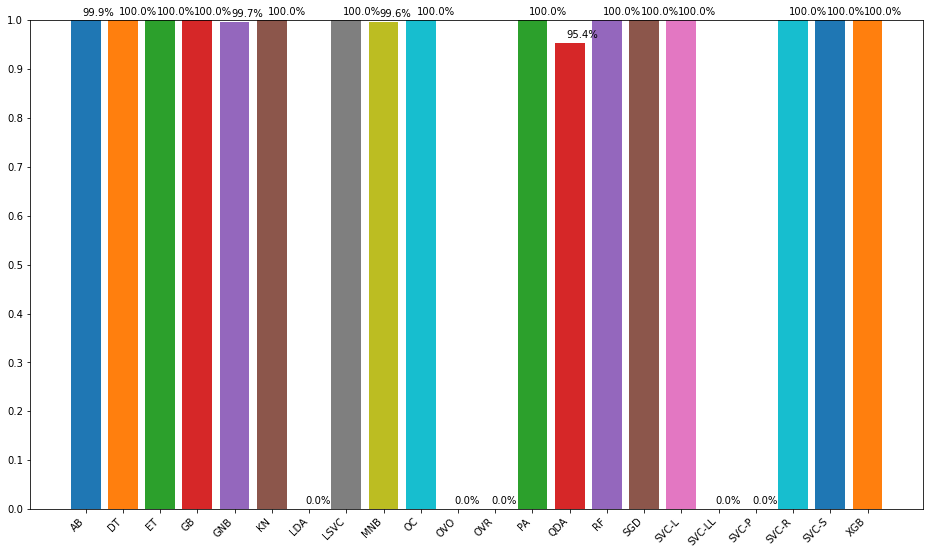

In [19]:
names = list(best_results.keys())
print(names)
values = list(x[0] for x in best_results.values())
print(values)

plt.figure(figsize=(16,9))
idx = 0
for i in range(len(best_results.keys())):
    plt.bar(names[i],values[i])
    plt.text(idx-0.1,values[i]+0.01,f'{100*values[i]:.1f}%')
    idx += 1
plt.xticks(rotation=45, ha='right')
plt.xticks(range(0,len(best_results)),names)
plt.yticks(np.linspace(0,1,11))
plt.ylim(0,1)
plt.show()

In [20]:
print(f"Execution finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Execution finished at 2022-02-23 03:24:23.
